### Common Pitfalls

1. **Label availability**:
After cleaning the data and removing duplicate emails, it became evident that less than half of the emails directly associate with age or birth year. This indicates that labels are not provided in the dataset, making it an unsupervised learning problem rather than a supervised one.

2. **Irrelevent features**:
Some features, such as length of usernames, do not contribute meaningful information for model training. If we had a large dataset with hundreds of thousands of emails and their corresponding ages, we could consider length as a feature and age as the label. However, this is not applicable in the current context.

3. **Incorrect Labeling**:
Using only usernames for training is problematic because these usernames are randomly generated. Extracting a 4-digit sequence from usernames to infer birth years (e.g., assuming "1990" in "anna1990@gmail.com" as the birth year) and using it as a label for supervised learning is incorrect. This approach leads to data leakage and model overfitting. If we assign labels to the emails with birth year and train a model, we are mistakenly assigning labels to usernames that are not nessarly associated with age or birth year. This introduces noise and bias into the target feature. This degrades the quality of the dataset and the model's performance.

4. **Misapplication of Supervised Models**:
Applying supervised learning models to this challenge is fundamentally wrong and demonstrates a misunderstanding of the problem. Achieving high accuracy with a supervised model in this context indicates overfitting to the training data. Such models will fail to generalize to out-of-distribution email samples and will not provide business value in a production environment.

In conclusion, without any labels, we must focus on engineering features from the emails and using appropriate unsupervised methods to classify them.

### Unsupervised Clustering
One of the well-known unsupervised machine learning methods is clustering, which is suitable for our task. Our goal is to assign each data sample to an age category. In this approach, we used three features to train the model and defined four clusters, each representing a different age category as well as 'unsure' category.

### External dataset
The "Popular Names by Birth Year (1880-2022)" dataset, provided by the USA Social Security Administration, is a publicly available resource accessible on [Kaggle](https://www.kaggle.com/datasets/ryanburnsworth/popular-names-by-birth-year-1880-2022?resource=download). It includes information such as the year of birth, name, gender of the child, and the number of children born with that name in a given year. This dataset provides valuable insights into the popularity of names across different years, aiding in understanding naming trends and patterns over time.

### Feature Engineering 
For feature eneingering we generate the following features:

1. **Firstname**:
    We determine the popularity of each first name within the specified age group using the "Popular Names by Birth Year" dataset.

2. **Birth year**:
    We extract either 4- or 2-digits sequences from the email that match the birth year pattern, indicating the potential year of birth for the individual.

3. **Domain**:
    We identify old email providers that are typically associated with older age groups. The presence of such domains in the email address suggests a higher likelihood of belonging to an older age group.

---
set matplotlib to widget for make the plot at the end of the notebook inteeractive.
Importing nessary module 

In [5]:
%matplotlib widget

from utils import preprocess_emails_to_df,preprocess_names_to_dict,get_scaled_features,gmm_fit_save,gmm_predict,make_dataset

These two helper functions load emails into a dataframe, and names dict is a dictonary where keys are years between 1940 and 2006.

In [6]:
emails_df = preprocess_emails_to_df("../emails.txt")
names_dict = preprocess_names_to_dict("./names_by_birth_year.csv")

Let's take a look at the year 2004 to see which names were popular that year. Note that while the total number of children born with a specific name is provided in the "count" column, this count is scaled for that year to be between 0 and 1. This scaling accounts for the varying number of births each year, as early years had fewer births compared to later years. Additionally, the "count_scaled" column is adjusted relative to gender. For example, "Emily" and "Jacob," the most popular names for females and males respectively, are both scaled to 1.

In [7]:
names_dict[2004].sort_values("count_scaled",ascending=False).head(10)

,year,name,gender,count,count_scaled
342945,2004,emily,F,25040,1.000000
361776,2004,jacob,M,27895,1.000000
361777,2004,michael,M,25465,0.912872
361778,2004,joshua,M,24210,0.867874
342946,2004,emma,F,21617,0.863271
342947,2004,madison,F,20628,0.823767
361779,2004,matthew,M,22881,0.820222
361780,2004,ethan,M,22208,0.796092
361781,2004,andrew,M,21712,0.778308
361782,2004,daniel,M,21000,0.752779


The internal fucntion `get_scaled_features`, tries to calculate features by 3 parameters: 1. Name, 2. Birth Year, and 3. Domain.

1. Name Extraction:

    First, we extract any consecutive three alphabetic strings from the username part of the email. For example, in "michael.kane1986@hotmail.com", we get['michael','kane']. Then we run these strings through the *names_dict* to determine which string is more common, identifying it as the *first name*. Note that not all emails *start* with the first name.

    After determinting the firstname, we create the "name" feature by summing the total scaled count divided by total years of that name in each "young", "middle" and "old" age groups. Check the "feature_name" values at the output and you will see name "micheal" is common between all age goups ("middle"~=1 - "old"~=0.8 - "young"~=9).

2. Birth Year Extraction:

    Next, we look for 4 or 2 digits in username. The 4 digit numbers must follow this pattern: 1940 to 2006 while 2 digits must be either 40 to 99 or 01 to 06. These are birth years that fit in our age groups. For example, the birth year in the username "michael.kane1986@hotmail.com" is **1986**.In the `feature_birth_year` output, the **middle** age group has a weight of 2. This decision was made to give more weight to a valid 4-digit birth year compared to the other two features: Name and Domain.

3. Domain Evaluation:
    Finally we check the domain, in the sample emails file provided, there are 3 email providers that existed from early times of the internet popularity: "AOL", "Hotmail" and "Mail". I also decided to add a small weight to "old" age group is domain is one of them. Check `feature_domain` and you will see **old** age group has weight of **0.3**.

After creating these three features, they are scaled and normalized into one `final_feature`. This feature value is then used for classification.

In [10]:
# Just for pretty print the features dictionary
import json

final_feature, all_features =  get_scaled_features(names_dict,emails_df.iloc[9]["email"])

print("Final Feature:")
print(final_feature)

print("All Features:")
print(json.dumps(all_features,sort_keys=True, indent=2))
 

Final Feature:
{'young': 0.18753922236561493, 'middle': 0.592067998572911, 'old': 0.22039277906147414}
All Features:
{
  "email": "michael.kane1986@hotmail.com",
  "feature_birth_year": {
    "middle": 2,
    "old": 0,
    "young": 0
  },
  "feature_domain": {
    "middle": 0,
    "old": 0.3,
    "young": 0
  },
  "feature_name": {
    "middle": 1.0086875775849569,
    "old": 0.8199609135267693,
    "young": 0.9530103467868541
  },
  "selected_birth_year": 1986,
  "selected_domain": "hotmail",
  "selected_name": "michael"
}


The dataset is made of the inputed email and calculated features for each one of them. It may take couple of minutes to make all the features depending on the number of emails.

In [11]:
dataset = make_dataset(emails_df,names_dict)
dataset.head()

,email,young,middle,old
0,elody_oconner51@gmail.com,0.000000,0.000000,1.000000
1,lily.long85@yahoo.com,0.063007,0.936003,0.000991
2,benjamin.phillips@hotmail.com,0.440058,0.217660,0.342283
3,robert.walker@aol.com,0.200368,0.236226,0.563406
4,samantha_turner1987@gmail.com,0.224758,0.771241,0.004001


After conducting several tests, I opted for the **Gaussian Mixture Model** (GMM) as it proves to be a robust unsupervised classification algorithm. The function below is commented out since it fits the classification model and saves it to the `gmm_model.pkl` file. There's no requirement to run this function as the model has already been committed to this repository.

In [12]:
#gmm_fit_save(dataset)

The predict function loads `gmm_model.pkl` file and classifies emails into four clusters: Young, Middle, Old, and Unsure. The confidence score is calculated by measuring the distance between the sample (email) and the maximum feature value of that cluster.

In [32]:
result = gmm_predict(dataset)
result.head(10)

,email,young,middle,old,cluster,conf
0,elody_oconner51@gmail.com,0.000000,0.000000,1.000000,3,1.00
1,lily.long85@yahoo.com,0.063007,0.936003,0.000991,0,0.91
2,benjamin.phillips@hotmail.com,0.440058,0.217660,0.342283,1,0.67
3,robert.walker@aol.com,0.200368,0.236226,0.563406,1,0.60
4,samantha_turner1987@gmail.com,0.224758,0.771241,0.004001,0,0.68
5,matthew7843@icloud.com,0.527458,0.410553,0.061990,2,0.37
6,jerrod_considine79@yahoo.com,0.001603,0.998166,0.000230,0,1.00
7,beverly_renner@outlook.com,0.061346,0.087004,0.851650,3,0.82
8,smith.kelly1996@aol.com,0.765536,0.080933,0.153531,2,0.71
9,michael.kane1986@hotmail.com,0.187539,0.592068,0.220393,0,0.50


But how do we determine which cluster corresponds to each age group? In unsupervised classification, this must be done through manual inspection. To facilitate this, we generate a 3D plot of features and clusters, with each cluster indicated by a different color. We can easily observer that middle cluster with blue color is **unsure**, yellow cluster where **old** values are closer to **1** is the **old** age group. Similary, **middle** and **young** are determined.

Feel free to interact with the plot by clicking and dragging the mouse. Note that the features are uniform and scaled.

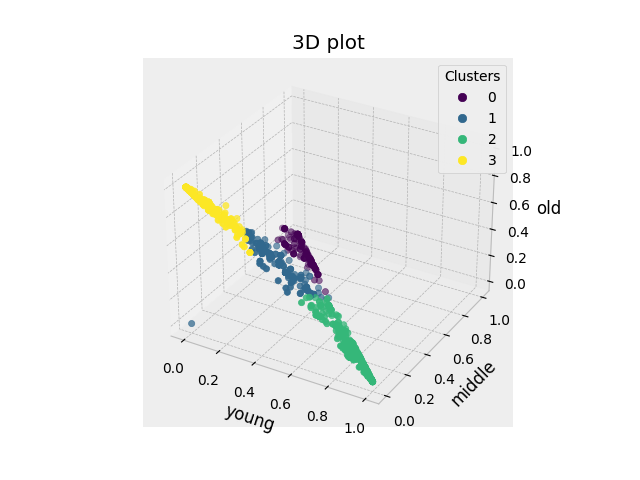

In [33]:
import matplotlib.pyplot as plt 

plt.style.use('bmh')
fig = plt.figure() 
ax = fig.add_subplot(projection='3d') 
  
# creating the plot 
plot_geeks = ax.scatter(data=result[["young","middle","old","cluster"]],xs='young',ys='middle',zs='old', c='cluster' ) 

  
# setting title and labels 
ax.set_title("3D plot") 
ax.set_xlabel('young') 
ax.set_ylabel('middle') 
ax.set_zlabel('old')

legend1 = ax.legend(*plot_geeks.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)

plt.show() 


We add the cluster names to the result database for better readablity.

In [34]:
result['cluster_name'] = "unsure"
result.loc[result['cluster']==0,'cluster_name'] = "middle"
result.loc[result['cluster']==2,'cluster_name'] = "young"
result.loc[result['cluster']==3,'cluster_name'] = "old"
 
result.groupby("cluster_name")["cluster_name"].count()

cluster_name
middle    170
old       248
unsure    192
young     311
Name: cluster_name, dtype: int64

## Conclusion

The solution outlined is not only applicable in theory or the provided dataset but also in real-world production environments. While many machine learning models are often viewed as black boxes, the proposed solution offers high explainability. It provides insight into how and why the model assigns an age category to each sample, making it transparent. This transparency is crucial for building trust and understanding in the model's predictions.